# Prueba de PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Dataframe
test_data = pd.read_csv("public_test.csv")
train_data = pd.read_csv("public_train.csv")

# Identificar columnas
TARGET = "ccs"
CATEGORICAL_FEATURES = ["adduct"]
NUMERIC_FEATURES = [col for col in train_data.columns if col.startswith("desc_")]
BINARY_FEATURES = [col for col in train_data.columns if col.startswith("fgp_")]

# Separar características y objetivo
x = train_data.drop(columns=[TARGET])  # Características
y = train_data[TARGET]  # Valor a estimar

# Dividir en datos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

class SimpleNN(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, hidden_dim=64, lr=0.001, epochs=100):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if(torch.device == "cpu"):
            print("cpu")
        else:
            print("gpu")

        # Red neuronal
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1)
        ).to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def fit(self, X, y):
        # X y y son ahora ndarray
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(self.device)

        for epoch in range(self.epochs):
            self.model.train()
            self.optimizer.zero_grad()
            predictions = self.model(X_tensor)
            loss = self.criterion(predictions, y_tensor)
            loss.backward()
            self.optimizer.step()

        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.cpu().numpy()


# Crear el modelo con los parámetros deseados
model_params = {'hidden_dim': 64, 'lr': 0.001, 'epochs': 40}

# Crear el pipeline de preprocesamiento y modelo
def create_preproc_and_model(numeric_features, categorical_features, binary_features):
    preprocessor = ColumnTransformer(
        transformers=[
            # Imputar valores faltantes y luego estandarizar los datos numéricos
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),  # Usar la media para imputar
                ('scaler', StandardScaler())
            ]), numeric_features),

            # Imputar valores faltantes en los datos categóricos y aplicar OneHotEncoder
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),  # Usar la moda para imputar
                ('onehot', OneHotEncoder())
            ]), categorical_features),

            # Imputar valores faltantes y luego estandarizar los datos binarios
            ('bin', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),  # Usar la moda para imputar
                ('scaler', StandardScaler())
            ]), binary_features)
        ])
    
    # Ajusta el preprocesador a los datos de entrenamiento
    preprocessor.fit(x_train)
    
    # Verificar la forma de los datos después del preprocesamiento
    x_train_transformed = preprocessor.transform(x_train)
    
    input_dim = x_train_transformed.shape[1]  # Número de características después del preprocesamiento
    model = SimpleNN(input_dim=input_dim, hidden_dim=128, lr=0.00001, epochs=50000)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipeline


pipeline = create_preproc_and_model(NUMERIC_FEATURES, CATEGORICAL_FEATURES, BINARY_FEATURES)

# Entrenar el modelo
pipeline.fit(x_train, y_train)

# Hacer predicciones
y_pred = pipeline.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

medae = median_absolute_error(y_test, y_pred)
print(f"Median Absolute Error (MedAE): {medae}")

gpu
Mean Squared Error (MSE): 147.30885027109505
Median Absolute Error (MedAE): 4.150285080566405


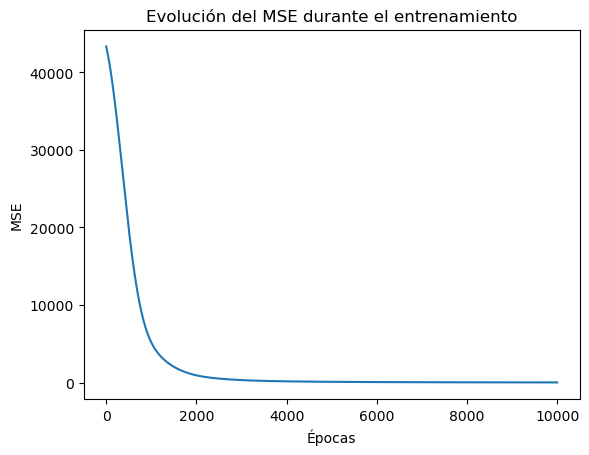

Mean Squared Error (MSE): 116.9233615886006
Median Absolute Error (MedAE): 4.135744589843739


In [ ]:
import matplotlib.pyplot as plt

class SimpleNN(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, hidden_dim=64, lr=0.001, epochs=100):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Red neuronal
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1)
        ).to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
        self.loss_history = []

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(self.device)

        for epoch in range(self.epochs):
            self.model.train()
            self.optimizer.zero_grad()
            predictions = self.model(X_tensor)
            loss = self.criterion(predictions, y_tensor)
            loss.backward()
            self.optimizer.step()

            # Guardar el MSE de cada época
            self.loss_history.append(loss.item())

        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.cpu().numpy()

# Crear el pipeline de preprocesamiento y modelo
def create_preproc_and_model(numeric_features, categorical_features, binary_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder())
            ]), categorical_features),
            ('bin', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler())
            ]), binary_features)
        ])

    preprocessor.fit(x_train)
    
    x_train_transformed = preprocessor.transform(x_train)
    
    input_dim = x_train_transformed.shape[1]
    model = SimpleNN(input_dim=input_dim, hidden_dim=512, lr=0.00003, epochs=10000)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipeline

pipeline = create_preproc_and_model(NUMERIC_FEATURES, CATEGORICAL_FEATURES, BINARY_FEATURES)

# Entrenar el modelo
pipeline.fit(x_train, y_train)

# Graficar la evolución del MSE
model = pipeline.named_steps['model']  # Obtener el modelo entrenado
plt.plot(model.loss_history)
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.title('Evolución del MSE durante el entrenamiento')
plt.show()

# Hacer predicciones
y_pred = pipeline.predict(x_test)

# Calcular y mostrar MSE y MedAE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

medae = median_absolute_error(y_test, y_pred)
print(f"Median Absolute Error (MedAE): {medae}")
